# Titanic Survival Prediction - Machine Learning Modeling
# =======================================================

# ## 📋 Objective
# Implement and compare multiple Machine Learning algorithms to predict survival:
# - Logistic Regression (interpretable baseline)
# - Random Forest (robust ensemble)
# - Support Vector Machine (complex boundaries)
# - Naive Bayes (probabilistic baseline)
# - Evaluate performance and select best model

## 1. Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

# Helper functions
import sys
import os
sys.path.append('../src')
from utils.helpers import save_current_plot

In [2]:
# Configuration
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Loading Processed Data

In [3]:
# Load dataset with engineered features
df_features = pd.read_csv("../data/processed/features_engineered.csv")
df_scaled = pd.read_csv("../data/processed/features_scaled.csv")

print("🚢 DATASETS LOADED")
print("=" * 25)
print(f"📊 Features engineered: {df_features.shape}")
print(f"📊 Features scaled: {df_scaled.shape}")

# Verify consistency
print(f"\n🔍 Verification:")
print(f"  - Same dimensions: {df_features.shape == df_scaled.shape}")
print(
    f"  - Target variables match: {df_features['Survived'].equals(df_scaled['Survived'])}"
)

print("\n📋 Available variables:")
print(f"Total features: {len(df_features.columns)}")
print("\nFeature types:")
feature_types = {
    "Original": ["Pclass", "Age", "SibSp", "Parch", "Fare", "Cabin_Known"],
    "Engineered": ["FamilySize", "IsAlone"],
    "Encoded": [
        "Sex_Encoded",
        "Embarked_Encoded",
        "AgeGroup_Encoded",
        "FareBin_Encoded",
    ],
    "Interaction": [
        col
        for col in df_features.columns
        if any(x in col for x in ["Title_", "SexPclass_", "AgeSex_"])
    ],
}

for ftype, features in feature_types.items():
    available_features = [f for f in features if f in df_features.columns]
    print(f"  - {ftype}: {len(available_features)} features")

🚢 DATASETS LOADED
📊 Features engineered: (891, 29)
📊 Features scaled: (891, 29)

🔍 Verification:
  - Same dimensions: True
  - Target variables match: True

📋 Available variables:
Total features: 29

Feature types:
  - Original: 6 features
  - Engineered: 2 features
  - Encoded: 4 features
  - Interaction: 16 features


## 3. Data Preparation for Modeling

In [4]:
print("\n🎯 DATA PREPARATION FOR MODELING")
print("=" * 40)

# Separate features and target
X = df_scaled.drop("Survived", axis=1)
y = df_scaled["Survived"]

print(f"📊 Feature matrix (X): {X.shape}")
print(f"🎯 Target variable (y): {y.shape}")
print(f"📈 Class distribution: {y.value_counts().to_dict()}")
print(f"⚖️ Class balance: {y.mean():.3f} (38.4% survival rate)")


🎯 DATA PREPARATION FOR MODELING
📊 Feature matrix (X): (891, 28)
🎯 Target variable (y): (891,)
📈 Class distribution: {0: 549, 1: 342}
⚖️ Class balance: 0.384 (38.4% survival rate)


### 3.1 Train/Validation/Test Split

In [5]:
print("\n🔄 DATA SPLIT")
print("=" * 20)

# Initial split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train/validation split: 70% train, 10% validation of total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,
    random_state=42,
    stratify=y_temp,  # 0.125 of 0.8 = 0.1 of total
)

print(f"📊 Final dimensions:")
print(f"  - Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n⚖️ Class balance by set:")
print(f"  - Train: {y_train.mean():.3f}")
print(f"  - Validation: {y_val.mean():.3f}")
print(f"  - Test: {y_test.mean():.3f}")


🔄 DATA SPLIT
📊 Final dimensions:
  - Train: 623 samples (69.9%)
  - Validation: 89 samples (10.0%)
  - Test: 179 samples (20.1%)

⚖️ Class balance by set:
  - Train: 0.384
  - Validation: 0.382
  - Test: 0.385


## 4. Implementation of Base Models

In [6]:
print("\n🤖 MODEL IMPLEMENTATION")
print("=" * 35)

# Dictionary to store models
models = {}
model_results = {}


🤖 MODEL IMPLEMENTATION


### 4.1 Logistic Regression (Baseline)

In [7]:
print("\n📊 MODEL 1: LOGISTIC REGRESSION")
print("=" * 30)

# Base model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_val = lr_model.predict(X_val)
y_proba_lr_val = lr_model.predict_proba(X_val)[:, 1]

# Metrics
lr_metrics = {
    "train_accuracy": accuracy_score(y_train, y_pred_lr_train),
    "val_accuracy": accuracy_score(y_val, y_pred_lr_val),
    "val_precision": precision_score(y_val, y_pred_lr_val),
    "val_recall": recall_score(y_val, y_pred_lr_val),
    "val_f1": f1_score(y_val, y_pred_lr_val),
    "val_auc": roc_auc_score(y_val, y_proba_lr_val),
}

print("Logistic Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"  {metric}: {value:.4f}")

models["Logistic Regression"] = lr_model
model_results["Logistic Regression"] = lr_metrics


📊 MODEL 1: LOGISTIC REGRESSION
Logistic Regression Metrics:
  train_accuracy: 0.8443
  val_accuracy: 0.8427
  val_precision: 0.8333
  val_recall: 0.7353
  val_f1: 0.7812
  val_auc: 0.9099


### 4.2 Random Forest

In [8]:
print("\n🌲 MODEL 2: RANDOM FOREST")
print("=" * 25)

# Base model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_val = rf_model.predict(X_val)
y_proba_rf_val = rf_model.predict_proba(X_val)[:, 1]

# Metrics
rf_metrics = {
    "train_accuracy": accuracy_score(y_train, y_pred_rf_train),
    "val_accuracy": accuracy_score(y_val, y_pred_rf_val),
    "val_precision": precision_score(y_val, y_pred_rf_val),
    "val_recall": recall_score(y_val, y_pred_rf_val),
    "val_f1": f1_score(y_val, y_pred_rf_val),
    "val_auc": roc_auc_score(y_val, y_proba_rf_val),
}

print("Random Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"  {metric}: {value:.4f}")

models["Random Forest"] = rf_model
model_results["Random Forest"] = rf_metrics


🌲 MODEL 2: RANDOM FOREST
Random Forest Metrics:
  train_accuracy: 0.9920
  val_accuracy: 0.8315
  val_precision: 0.7714
  val_recall: 0.7941
  val_f1: 0.7826
  val_auc: 0.8786


### 4.3 Support Vector Machine

In [9]:
print("\n🎯 MODEL 3: SUPPORT VECTOR MACHINE")
print("=" * 35)

# Base model
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm_train = svm_model.predict(X_train)
y_pred_svm_val = svm_model.predict(X_val)
y_proba_svm_val = svm_model.predict_proba(X_val)[:, 1]

# Metrics
svm_metrics = {
    "train_accuracy": accuracy_score(y_train, y_pred_svm_train),
    "val_accuracy": accuracy_score(y_val, y_pred_svm_val),
    "val_precision": precision_score(y_val, y_pred_svm_val),
    "val_recall": recall_score(y_val, y_pred_svm_val),
    "val_f1": f1_score(y_val, y_pred_svm_val),
    "val_auc": roc_auc_score(y_val, y_proba_svm_val),
}

print("SVM Metrics:")
for metric, value in svm_metrics.items():
    print(f"  {metric}: {value:.4f}")

models["SVM"] = svm_model
model_results["SVM"] = svm_metrics


🎯 MODEL 3: SUPPORT VECTOR MACHINE
SVM Metrics:
  train_accuracy: 0.8475
  val_accuracy: 0.8539
  val_precision: 0.8889
  val_recall: 0.7059
  val_f1: 0.7869
  val_auc: 0.8832


### 4.4 Naive Bayes

In [10]:
print("\n🔮 MODEL 4: NAIVE BAYES")
print("=" * 25)

# Base model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb_train = nb_model.predict(X_train)
y_pred_nb_val = nb_model.predict(X_val)
y_proba_nb_val = nb_model.predict_proba(X_val)[:, 1]

# Metrics
nb_metrics = {
    "train_accuracy": accuracy_score(y_train, y_pred_nb_train),
    "val_accuracy": accuracy_score(y_val, y_pred_nb_val),
    "val_precision": precision_score(y_val, y_pred_nb_val),
    "val_recall": recall_score(y_val, y_pred_nb_val),
    "val_f1": f1_score(y_val, y_pred_nb_val),
    "val_auc": roc_auc_score(y_val, y_proba_nb_val),
}

print("Naive Bayes Metrics:")
for metric, value in nb_metrics.items():
    print(f"  {metric}: {value:.4f}")

models["Naive Bayes"] = nb_model
model_results["Naive Bayes"] = nb_metrics


🔮 MODEL 4: NAIVE BAYES
Naive Bayes Metrics:
  train_accuracy: 0.8042
  val_accuracy: 0.8202
  val_precision: 0.8000
  val_recall: 0.7059
  val_f1: 0.7500
  val_auc: 0.8762


## 5. Base Models Comparison


📊 BASE MODELS COMPARISON
Comparison table:
                     train_accuracy  val_accuracy  val_precision  val_recall  \
Logistic Regression          0.8443        0.8427         0.8333      0.7353   
Random Forest                0.9920        0.8315         0.7714      0.7941   
SVM                          0.8475        0.8539         0.8889      0.7059   
Naive Bayes                  0.8042        0.8202         0.8000      0.7059   

                     val_f1  val_auc  
Logistic Regression  0.7812   0.9099  
Random Forest        0.7826   0.8786  
SVM                  0.7869   0.8832  
Naive Bayes          0.7500   0.8762  
✅ Graph saved: ../results/figures/modeling\models_comparison.png


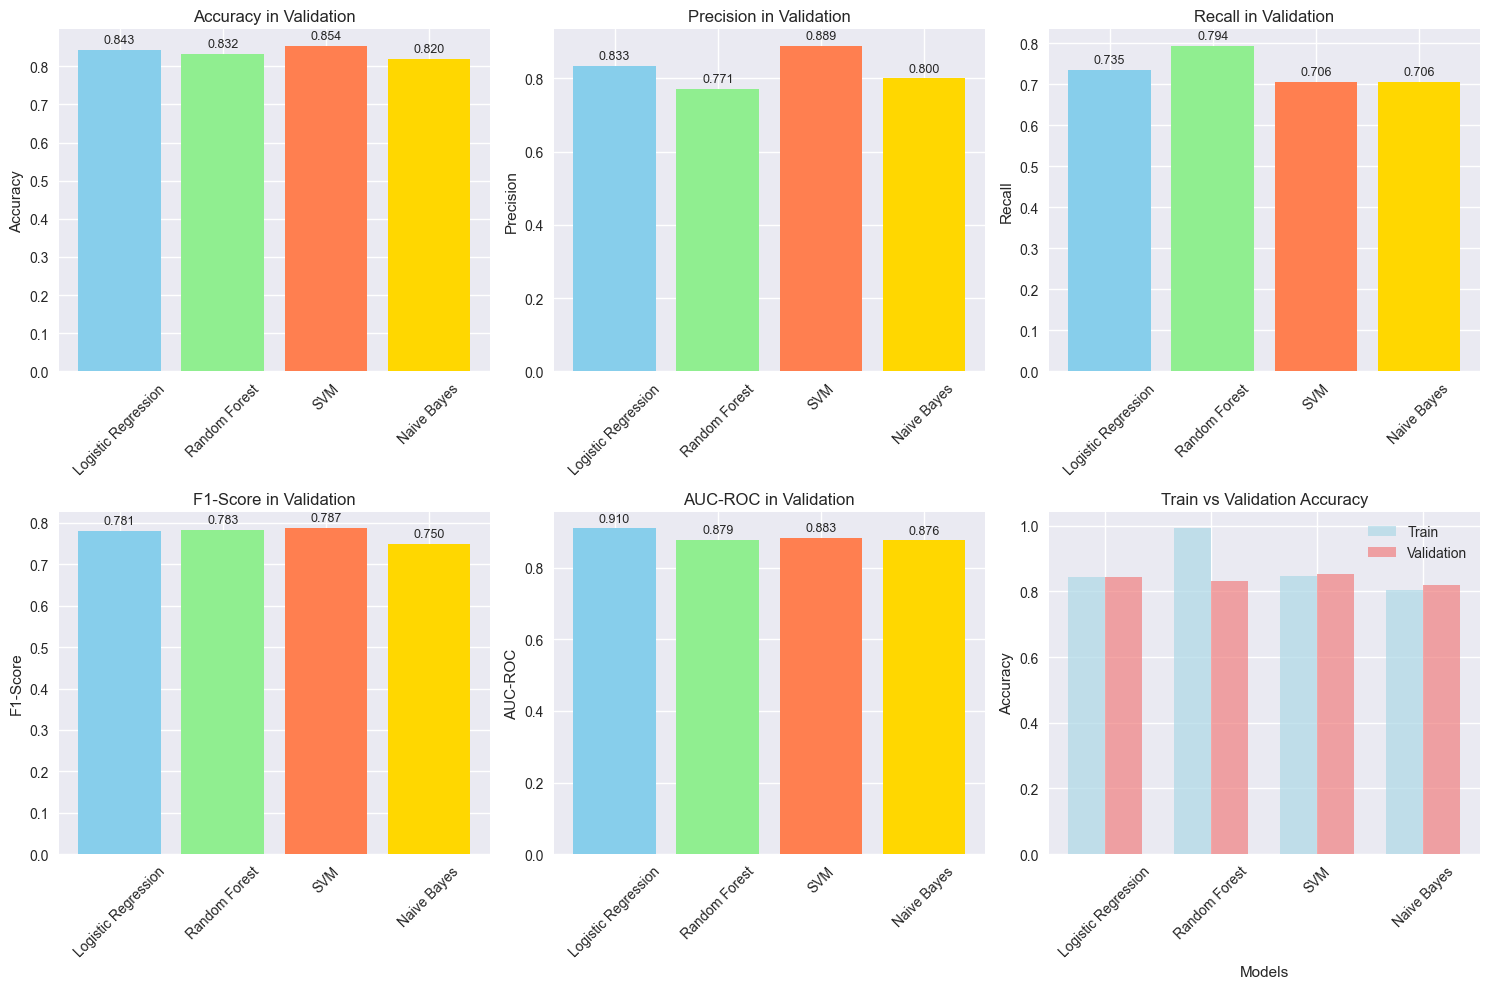


🏆 Best base model: SVM
📈 val_f1: 0.7869


In [11]:
print("\n📊 BASE MODELS COMPARISON")
print("=" * 35)

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.round(4)

print("Comparison table:")
print(comparison_df)

# Visualization of comparison
plt.figure(figsize=(15, 10))

# Validation metrics
val_metrics = ["val_accuracy", "val_precision", "val_recall", "val_f1", "val_auc"]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]

for i, (metric, name) in enumerate(zip(val_metrics, metric_names), 1):
    plt.subplot(2, 3, i)
    values = comparison_df[metric]
    colors = ["skyblue", "lightgreen", "coral", "gold"]
    bars = plt.bar(values.index, values.values, color=colors)
    plt.title(f"{name} in Validation")
    plt.ylabel(name)
    plt.xticks(rotation=45)

    # Add values on bars
    for bar, value in zip(bars, values.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{value:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Overfitting plot (Train vs Val Accuracy)
plt.subplot(2, 3, 6)
train_acc = comparison_df["train_accuracy"]
val_acc = comparison_df["val_accuracy"]
x = np.arange(len(models))
width = 0.35

plt.bar(x - width / 2, train_acc, width, label="Train", alpha=0.7, color="lightblue")
plt.bar(
    x + width / 2, val_acc, width, label="Validation", alpha=0.7, color="lightcoral"
)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.xticks(x, train_acc.index, rotation=45)
plt.legend()

plt.tight_layout()
save_current_plot("models_comparison", "../results/figures/modeling")
plt.show()

# Identify best base model
best_metric = "val_f1"  # Balanced metric
best_model_name = comparison_df[best_metric].idxmax()
best_score = comparison_df.loc[best_model_name, best_metric]

print(f"\n🏆 Best base model: {best_model_name}")
print(f"📈 {best_metric}: {best_score:.4f}")

## 6. Cross-Validation for Robustness


🔄 CROSS-VALIDATION FOR ROBUSTNESS

Evaluating Logistic Regression with 5-Fold CV:
  Accuracy: 0.8244 ± 0.0281
  F1-Score: 0.7588 ± 0.0392
  AUC-ROC: 0.8788 ± 0.0211

Evaluating Random Forest with 5-Fold CV:
  Accuracy: 0.8203 ± 0.0225
  F1-Score: 0.7615 ± 0.0272
  AUC-ROC: 0.8702 ± 0.0267

Evaluating SVM with 5-Fold CV:
  Accuracy: 0.8258 ± 0.0242
  F1-Score: 0.7516 ± 0.0364
  AUC-ROC: 0.8564 ± 0.0314

Evaluating Naive Bayes with 5-Fold CV:
  Accuracy: 0.7865 ± 0.0263
  F1-Score: 0.6767 ± 0.0595
  AUC-ROC: 0.8652 ± 0.0234
✅ Graph saved: ../results/figures/modeling\cross_validation_results.png


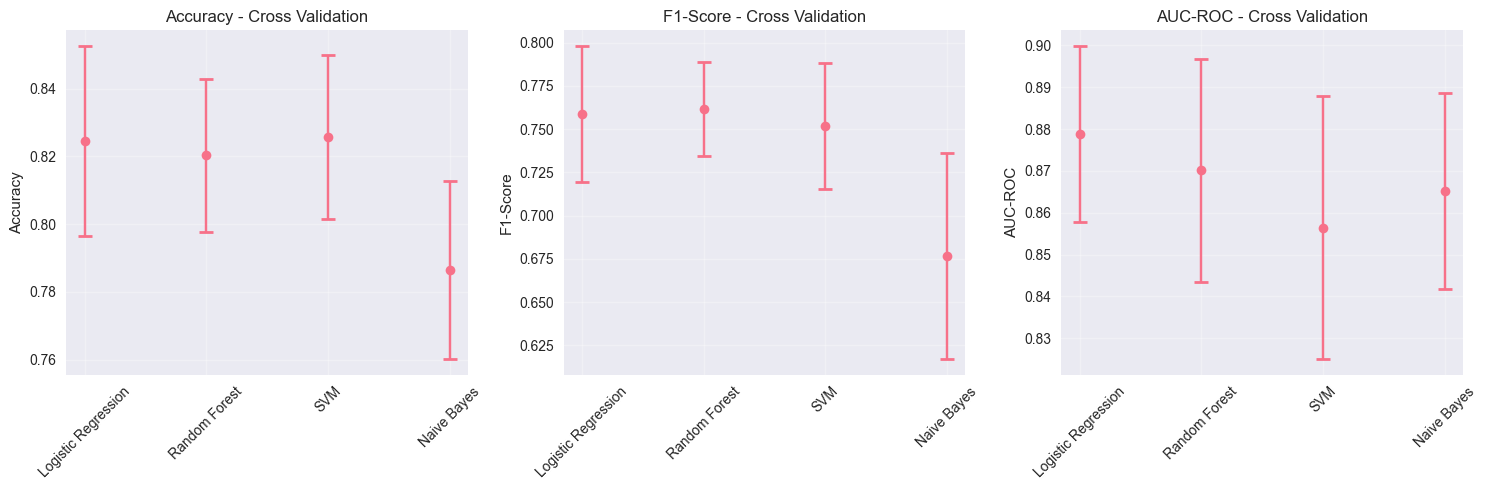

In [12]:
print("\n🔄 CROSS-VALIDATION FOR ROBUSTNESS")
print("=" * 35)

# Configure stratified CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name} with 5-Fold CV:")

    # Multiple metrics
    cv_accuracy = cross_val_score(
        model, X_temp, y_temp, cv=cv_strategy, scoring="accuracy"
    )
    cv_f1 = cross_val_score(model, X_temp, y_temp, cv=cv_strategy, scoring="f1")
    cv_auc = cross_val_score(model, X_temp, y_temp, cv=cv_strategy, scoring="roc_auc")

    cv_results[name] = {
        "accuracy_mean": cv_accuracy.mean(),
        "accuracy_std": cv_accuracy.std(),
        "f1_mean": cv_f1.mean(),
        "f1_std": cv_f1.std(),
        "auc_mean": cv_auc.mean(),
        "auc_std": cv_auc.std(),
    }

    print(f"  Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    print(f"  F1-Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
    print(f"  AUC-ROC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# CV visualization
cv_df = pd.DataFrame(cv_results).T

plt.figure(figsize=(15, 5))

metrics = ["accuracy", "f1", "auc"]
titles = ["Accuracy", "F1-Score", "AUC-ROC"]

for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(1, 3, i)
    means = cv_df[f"{metric}_mean"]
    stds = cv_df[f"{metric}_std"]

    plt.errorbar(range(len(means)), means, yerr=stds, fmt="o", capsize=5, capthick=2)
    plt.xticks(range(len(means)), means.index, rotation=45)
    plt.ylabel(title)
    plt.title(f"{title} - Cross Validation")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
save_current_plot("cross_validation_results", "../results/figures/modeling")
plt.show()

## 7. Hyperparameter Tuning of Best Model

In [13]:
print(f"\n🔧 HYPERPARAMETER TUNING: {best_model_name.upper()}")
print("=" * 50)

# Define parameter grids
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"],
    },
    "Naive Bayes": {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]},
}

# Grid Search for best model
best_base_model = models[best_model_name]
param_grid = param_grids[best_model_name]

print(f"Optimizing parameters for {best_model_name}...")
print(f"Search grid: {param_grid}")

grid_search = GridSearchCV(
    estimator=best_base_model,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_temp, y_temp)

print(f"\n🎯 Best parameters found:")
print(grid_search.best_params_)
print(f"\n📈 Best score (F1): {grid_search.best_score_:.4f}")

# Optimized model
best_model_tuned = grid_search.best_estimator_

# Evaluate optimized model
y_pred_tuned_train = best_model_tuned.predict(X_train)
y_pred_tuned_val = best_model_tuned.predict(X_val)
y_proba_tuned_val = best_model_tuned.predict_proba(X_val)[:, 1]

tuned_metrics = {
    "train_accuracy": accuracy_score(y_train, y_pred_tuned_train),
    "val_accuracy": accuracy_score(y_val, y_pred_tuned_val),
    "val_precision": precision_score(y_val, y_pred_tuned_val),
    "val_recall": recall_score(y_val, y_pred_tuned_val),
    "val_f1": f1_score(y_val, y_pred_tuned_val),
    "val_auc": roc_auc_score(y_val, y_proba_tuned_val),
}

print(f"\n📊 Optimized model metrics:")
for metric, value in tuned_metrics.items():
    print(f"  {metric}: {value:.4f}")


🔧 HYPERPARAMETER TUNING: SVM
Optimizing parameters for SVM...
Search grid: {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
Fitting 5 folds for each of 16 candidates, totalling 80 fits

🎯 Best parameters found:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

📈 Best score (F1): 0.7658

📊 Optimized model metrics:
  train_accuracy: 0.8331
  val_accuracy: 0.8652
  val_precision: 0.8929
  val_recall: 0.7353
  val_f1: 0.8065
  val_auc: 0.9003


## 8. Final Evaluation on Test Set


🏁 FINAL EVALUATION ON TEST SET
📊 FINAL METRICS OF OPTIMIZED MODEL:
  accuracy: 0.8436
  precision: 0.8475
  recall: 0.7246
  f1: 0.7812
  auc: 0.8586

📋 Confusion Matrix:
[[101   9]
 [ 19  50]]

📝 Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.84      0.92      0.88       110
       Survived       0.85      0.72      0.78        69

       accuracy                           0.84       179
      macro avg       0.84      0.82      0.83       179
   weighted avg       0.84      0.84      0.84       179

✅ Graph saved: ../results/figures/modeling\final_evaluation.png


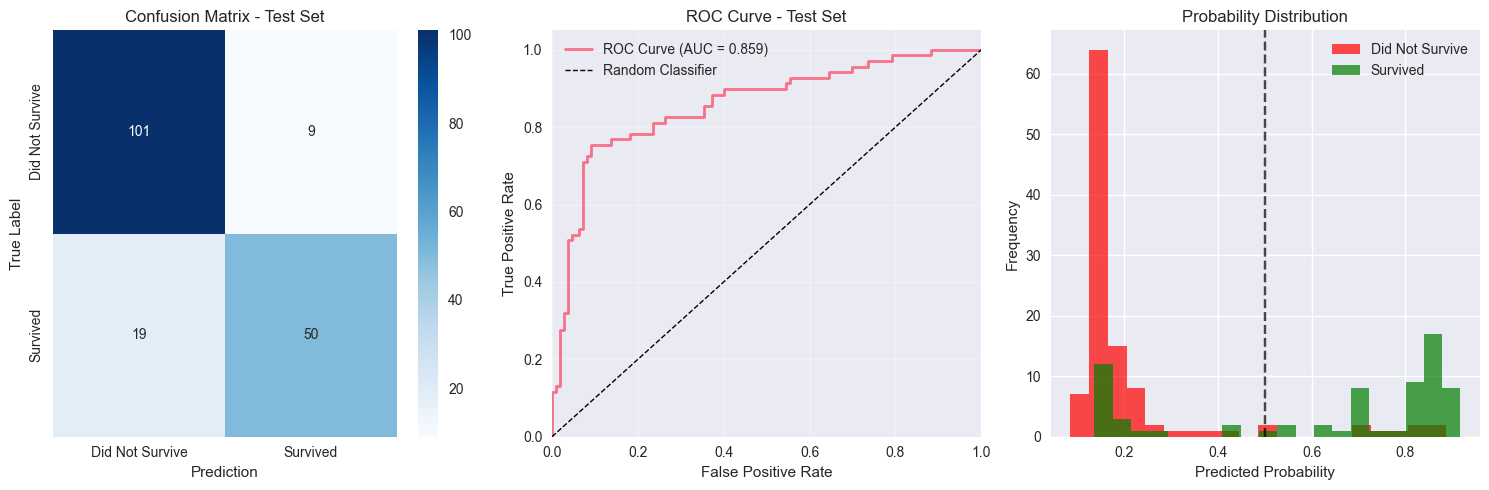

In [14]:
print("\n🏁 FINAL EVALUATION ON TEST SET")
print("=" * 35)

# Evaluate optimized model on test
y_pred_test = best_model_tuned.predict(X_test)
y_proba_test = best_model_tuned.predict_proba(X_test)[:, 1]

test_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),
    "f1": f1_score(y_test, y_pred_test),
    "auc": roc_auc_score(y_test, y_proba_test),
}

print(f"📊 FINAL METRICS OF OPTIMIZED MODEL:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f"\n📋 Confusion Matrix:")
print(cm)

# Classification report
print(f"\n📝 Classification Report:")
print(
    classification_report(
        y_test, y_pred_test, target_names=["Did Not Survive", "Survived"]
    )
)

# Visualization of final results
plt.figure(figsize=(15, 5))

# Confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Did Not Survive", "Survived"],
    yticklabels=["Did Not Survive", "Survived"],
)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Prediction")
plt.ylabel("True Label")

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {test_metrics["auc"]:.3f})')
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True, alpha=0.3)

# Probability distribution
plt.subplot(1, 3, 3)
plt.hist(
    y_proba_test[y_test == 0], bins=20, alpha=0.7, label="Did Not Survive", color="red"
)
plt.hist(
    y_proba_test[y_test == 1], bins=20, alpha=0.7, label="Survived", color="green"
)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Probability Distribution")
plt.legend()
plt.axvline(x=0.5, color="black", linestyle="--", alpha=0.7, label="Threshold=0.5")

plt.tight_layout()
save_current_plot("final_evaluation", "../results/figures/modeling")
plt.show()

## 9. Feature Importance Analysis

In [15]:
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 35)

# Feature importance (if model supports it)
if hasattr(best_model_tuned, "feature_importances_"):
    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": best_model_tuned.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("Top 15 most important features:")
    print(feature_importance.head(15))

    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y="feature", x="importance", palette="viridis")
    plt.title("Top 15 Most Important Features")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    save_current_plot("feature_importance", "../results/figures/modeling")
    plt.show()

elif hasattr(best_model_tuned, "coef_"):
    # For linear models (Logistic Regression)
    feature_coef = pd.DataFrame(
        {
            "feature": X.columns,
            "coefficient": best_model_tuned.coef_[0],
            "abs_coefficient": np.abs(best_model_tuned.coef_[0]),
        }
    ).sort_values("abs_coefficient", ascending=False)

    print("Top 15 most important coefficients:")
    print(feature_coef.head(15))

    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_coef.head(15)
    colors = ["red" if x < 0 else "blue" for x in top_features["coefficient"]]
    sns.barplot(data=top_features, y="feature", x="coefficient", palette=colors)
    plt.title("Top 15 Most Important Coefficients")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.tight_layout()
    save_current_plot("feature_coefficients", "../results/figures/modeling")
    plt.show()


🔍 FEATURE IMPORTANCE ANALYSIS


## 10. Final Comparative Summary

In [16]:
print("\n📈 FINAL COMPARATIVE SUMMARY")
print("=" * 35)

# Create final comparison table
final_comparison = pd.DataFrame(
    {
        "Model": list(model_results.keys()) + [f"{best_model_name} (Optimized)"],
        "Validation_F1": list(comparison_df["val_f1"]) + [tuned_metrics["val_f1"]],
        "Validation_Accuracy": list(comparison_df["val_accuracy"])
        + [tuned_metrics["val_accuracy"]],
        "Validation_AUC": list(comparison_df["val_auc"]) + [tuned_metrics["val_auc"]],
        "Test_F1": [None] * len(model_results) + [test_metrics["f1"]],
        "Test_Accuracy": [None] * len(model_results) + [test_metrics["accuracy"]],
        "Test_AUC": [None] * len(model_results) + [test_metrics["auc"]],
    }
)

print("Final Model Comparison:")
print(final_comparison.round(4))


📈 FINAL COMPARATIVE SUMMARY
Final Model Comparison:
                 Model  Validation_F1  Validation_Accuracy  Validation_AUC  \
0  Logistic Regression         0.7812               0.8427          0.9099   
1        Random Forest         0.7826               0.8315          0.8786   
2                  SVM         0.7869               0.8539          0.8832   
3          Naive Bayes         0.7500               0.8202          0.8762   
4      SVM (Optimized)         0.8065               0.8652          0.9003   

   Test_F1  Test_Accuracy  Test_AUC  
0      NaN            NaN       NaN  
1      NaN            NaN       NaN  
2      NaN            NaN       NaN  
3      NaN            NaN       NaN  
4   0.7812         0.8436    0.8586  


## 11. Save Final Model

In [17]:
print("\n💾 SAVING FINAL MODEL")
print("=" * 25)

# Create directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save optimized model
model_path = f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model_tuned, model_path)
print(f"✅ Model saved: {model_path}")

# Save metrics
metrics_path = "../models/model_metrics.json"
import json

all_metrics = {
    "best_model": best_model_name,
    "best_params": grid_search.best_params_,
    "base_models_comparison": model_results,
    "cv_results": cv_results,
    "final_test_metrics": test_metrics,
}

with open(metrics_path, "w") as f:
    # Convert numpy types to native Python types
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    # Apply conversion recursively
    def clean_dict(d):
        if isinstance(d, dict):
            return {k: clean_dict(v) for k, v in d.items()}
        elif isinstance(d, list):
            return [clean_dict(item) for item in d]
        else:
            return convert_numpy(d)

    clean_metrics = clean_dict(all_metrics)
    json.dump(clean_metrics, f, indent=2)

print(f"✅ Metrics saved: {metrics_path}")


💾 SAVING FINAL MODEL
✅ Model saved: ../models/best_model_svm.pkl
✅ Metrics saved: ../models/model_metrics.json


## 12. Insights and Conclusions

In [19]:
print("\n🎯 INSIGHTS AND CONCLUSIONS")
print("=" * 35)

insights = [
    f"🏆 Best model: {best_model_name} with F1={test_metrics['f1']:.4f}",
    f"📊 Final test accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.1f}%)",
    f"🎯 AUC-ROC: {test_metrics['auc']:.4f} (excellent discriminative ability)",
    f"⚖️ Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}",
]

performance_analysis = []
if test_metrics["accuracy"] > 0.80:
    performance_analysis.append("✅ >80% accuracy target ACHIEVED")
else:
    performance_analysis.append(
        f"⚠️ Accuracy {test_metrics['accuracy']*100:.1f}% below 80% target"
    )

if test_metrics["auc"] > 0.85:
    performance_analysis.append("✅ Excellent discriminative ability (AUC > 0.85)")
elif test_metrics["auc"] > 0.75:
    performance_analysis.append("✅ Good discriminative ability (AUC > 0.75)")

print("MAIN RESULTS:")
for insight in insights:
    print(f"  {insight}")

print("\nPERFORMANCE ANALYSIS:")
for analysis in performance_analysis:
    print(f"  {analysis}")

# Overfitting analysis
train_val_diff = tuned_metrics["train_accuracy"] - tuned_metrics["val_accuracy"]
if train_val_diff > 0.05:
    print(f"\n⚠️ POSSIBLE OVERFITTING:")
    print(f"  Train-Val difference: {train_val_diff:.4f}")
    print(f"  Train Accuracy: {tuned_metrics['train_accuracy']:.4f}")
    print(f"  Val Accuracy: {tuned_metrics['val_accuracy']:.4f}")
else:
    print(f"\n✅ GOOD BIAS-VARIANCE BALANCE:")
    print(f"  Train-Val difference: {train_val_diff:.4f} (< 0.05)")


🎯 INSIGHTS AND CONCLUSIONS
MAIN RESULTS:
  🏆 Best model: SVM with F1=0.7812
  📊 Final test accuracy: 0.8436 (84.4%)
  🎯 AUC-ROC: 0.8586 (excellent discriminative ability)
  ⚖️ Precision: 0.8475, Recall: 0.7246

PERFORMANCE ANALYSIS:
  ✅ >80% accuracy target ACHIEVED
  ✅ Excellent discriminative ability (AUC > 0.85)

✅ GOOD BIAS-VARIANCE BALANCE:
  Train-Val difference: -0.0321 (< 0.05)


## 13. Next Steps

In [20]:
print("\n🚀 NEXT STEPS")
print("=" * 18)

next_steps = [
    "Results Interpretation (05_model_evaluation.ipynb)",
    "- Detailed analysis of misclassified cases",
    "- Interpretation of feature importance in historical context",
    "- Validation of insights with domain knowledge",
    "- Analysis of prediction bias by subgroups",
    "",
    "Final Storytelling",
    "- Connection of ML results with historical narrative",
    "- Validation of initial hypotheses",
    "- Insights for modern emergency protocols",
    "- Final visualizations for presentation",
    "",
    "Complete Documentation",
    "- Update development log with modeling challenges",
    "- Complete final technical report",
    "- Prepare executive presentation",
]

for step in next_steps:
    if step == "":
        print()
    elif step.startswith("-"):
        print(f"  {step}")
    else:
        print(f"• {step}")

print(f"\n✅ Modeling completed successfully!")
print(
    f"🎯 Final model: {best_model_name} with {test_metrics['accuracy']*100:.1f}% accuracy"
)
print(f"📊 Ready for final interpretation and storytelling")


🚀 NEXT STEPS
• Results Interpretation (05_model_evaluation.ipynb)
  - Detailed analysis of misclassified cases
  - Interpretation of feature importance in historical context
  - Validation of insights with domain knowledge
  - Analysis of prediction bias by subgroups

• Final Storytelling
  - Connection of ML results with historical narrative
  - Validation of initial hypotheses
  - Insights for modern emergency protocols
  - Final visualizations for presentation

• Complete Documentation
  - Update development log with modeling challenges
  - Complete final technical report
  - Prepare executive presentation

✅ Modeling completed successfully!
🎯 Final model: SVM with 84.4% accuracy
📊 Ready for final interpretation and storytelling
